In [1]:
!pip install scikit-learn

In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import io
import unicodedata
import re
import os
from sklearn.model_selection import train_test_split
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
input_file = 'divina_textonly.txt'
target_file = 'divina_syll_textonly.txt'

In [ ]:
input_text_raw = open(input_file, 'rb').read().decode(encoding='utf-8')
target_text_raw = open(target_file, 'rb').read().decode(encoding='utf-8')
print('Length of input text: {} characters'.format(len(input_text_raw)))
print('Length of target text: {} characters'.format(len(target_text_raw)))

In [5]:
input_vocab = sorted(set(input_text_raw))
target_vocab = sorted(set(target_text_raw))
input_vocab_size = len(input_vocab)
target_vocab_size = len(target_vocab)

In [6]:
print('Input vocab size: {}'.format(input_vocab_size))
print('Target vocab size: {}'.format(target_vocab_size))

Input vocab size: 80
Target vocab size: 81


In [8]:
def preprocess(text):
    return ['^' + line.strip() + '$' for line in text.split('\n') if line.strip() != '']

input_text_prepr = preprocess(input_text_raw)
target_text_prepr = preprocess(target_text_raw)

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(target_text_prepr)

input_text_lines_enc = tokenizer.texts_to_sequences(input_text_prepr)
target_text_lines_enc = tokenizer.texts_to_sequences(target_text_prepr)

In [10]:
def pad(x):
    return tf.keras.preprocessing.sequence.pad_sequences(x, padding='post') 

In [11]:
input_text = pad(input_text_lines_enc)
target_text = pad(target_text_lines_enc)

In [12]:
input_train, input_test, target_train, target_test = train_test_split(input_text, target_text)

In [13]:
BUFFER_SIZE = len(input_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_train)//BATCH_SIZE

vocab_size = len(tokenizer.word_index)+1

max_length_targ, max_length_inp = target_text.shape[1], input_text.shape[1]

dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
dataset

<BatchDataset shapes: ((64, 55), (64, 65)), types: (tf.int32, tf.int32)>

In [56]:
print(enumerate(dataset))

Passo a transformers

In [15]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 1024, 256)


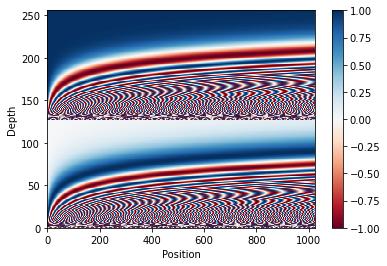

In [18]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [19]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [21]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [24]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [27]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [30]:
num_layers = 4
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [34]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [35]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [36]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [41]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [37]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [38]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

#train_step_signature = [
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#]


#@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [42]:
EPOCHS=10
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 5.4522 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.1558 Accuracy 0.1179
Epoch 1 Batch 100 Loss 3.5987 Accuracy 0.1674
Epoch 1 Batch 150 Loss 3.3274 Accuracy 0.1950
Epoch 1 Loss 3.2478 Accuracy 0.2064
Time taken for 1 epoch: 70.01 secs

Epoch 2 Batch 0 Loss 2.3400 Accuracy 0.3456
Epoch 2 Batch 50 Loss 2.1810 Accuracy 0.3658
Epoch 2 Batch 100 Loss 2.0821 Accuracy 0.3826
Epoch 2 Batch 150 Loss 2.0115 Accuracy 0.3942
Epoch 2 Loss 1.9928 Accuracy 0.3976
Time taken for 1 epoch: 67.21 secs

Epoch 3 Batch 0 Loss 1.7794 Accuracy 0.4357
Epoch 3 Batch 50 Loss 1.7531 Accuracy 0.4422
Epoch 3 Batch 100 Loss 1.7150 Accuracy 0.4523
Epoch 3 Batch 150 Loss 1.6765 Accuracy 0.4630
Epoch 3 Loss 1.6644 Accuracy 0.4664
Time taken for 1 epoch: 67.01 secs

Epoch 4 Batch 0 Loss 1.5032 Accuracy 0.5077
Epoch 4 Batch 50 Loss 1.4854 Accuracy 0.5185
Epoch 4 Batch 100 Loss 1.4094 Accuracy 0.5428
Epoch 4 Batch 150 Loss 1.2858 Accuracy 0.5833
Epoch 4 Loss 1.2412 Accuracy 0.5981
Time taken for 1 epoch: 

In [65]:
def evaluate(sentence, max_length=200):
  
  encoder_input = [tokenizer.word_index[i] for i in list(map(str, sentence))]
  encoder_input = tf.keras.preprocessing.sequence.pad_sequences([encoder_input],
                                                         maxlen=max_length,
                                                         padding='post')
  encoder_input = tf.convert_to_tensor(encoder_input)

  output = tf.convert_to_tensor([tokenizer.word_index['^']])
  output = tf.expand_dims(output, 0)
  result = ''

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([tf.cast(output, dtype=tf.int32), tf.cast(predicted_id, dtype=tf.int32)], axis=-1)
    result += tokenizer.index_word[predicted_id.numpy()[0][0]] + ' '

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer.word_index['$']:
      break

  # output.shape (1, tokens)
  #text = tokenizers.en.detokenize(output)[0]  # shape: ()
  #tokens = tokenizers.en.lookup(output)[0]

  return result, attention_weights

In [61]:
def print_translation(sentence, result, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {result}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [66]:
sentence = "^Nel mezzo del cammin di nostra vita$"
ground_truth = "|Nel |mez|zo |del |cam|min |di |no|stra |vi|ta"


translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^Nel mezzo del cammin di nostra vita$
Prediction     : | N e l   | m e z | z o   | d e l   | c a m | m i n   | d i   | n o | s t r a   | v i | t a $ 
Ground truth   : |Nel |mez|zo |del |cam|min |di |no|stra |vi|ta


In [71]:
sentence = "^La spera ottava vi dimostra molti$"
ground_truth = "|La |spe|ra ot|ta|va |vi |di|mo|stra |mol|ti"

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^La spera ottava vi dimostra molti$
Prediction     : | L a   | s p e | r a   o t | t a | v a   | v i   | d i | m o | s t r a   | m o l | t i $ 
Ground truth   : |La |spe|ra ot|ta|va |vi |di|mo|stra |mol|ti


In [72]:
sentence = "^di’ quel ch’ell’ è, di’ come se ne ’nfiora$"
ground_truth = "|di’ |quel |ch’ el|l’ è, |di’ |co|me |se |ne ’n|fio|ra"

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^di’ quel ch’ell’ è, di’ come se ne ’nfiora$
Prediction     : | d i ’   | q u e l   | c h ’   e l | l ’   è ,   | d i ’   | c o | m e   | s e   | n e   ’ n | f i o | r a $ 
Ground truth   : |di’ |quel |ch’ el|l’ è, |di’ |co|me |se |ne ’n|fio|ra


In [69]:
sentence = "^Buongiorno$"
ground_truth = ""

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^Buongiorno$
Prediction     : | t u o n | g i o | r o | n o $ 
Ground truth   : 


In [75]:
sentence = "^è importante dormire otto ore$"
ground_truth = ""

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^è importante dormire otto ore$
Prediction     : | è   | i m | p o r | t a n | t e   | d o r | m i | r e   o t | t o   o | r e e $ 
Ground truth   : 


In [70]:
sentence = "^Mangio un panino$"
ground_truth = ""

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^Mangio un panino$
Prediction     : | M a n | g i o   | u n   | p a | n i | n o $ 
Ground truth   : 


In [76]:
sentence = "^Ilaria prepara la colazione$"
ground_truth = ""

translated_text, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ^Ilaria prepara la colazione$
Prediction     : | I | l a | r i   a | p r e | p a | r a   | l a   | c o l | z a i | n e $ 
Ground truth   : 
